## Reducing dimensions

### Introduction

OpenEO has a library of processes. Processes are pre-defined functions that perform a certain analysis on the satellite data. Some examples are operations like addition and multiplication or aggregations like mean and median. In this notebook we will show the process of reduction. It's an operation that will result in a reduced amount of dimensions in the Datacube.

### Objective

The objective of this tutorial is to teach you how a process works in action and explain the process of reduction.

### In this lesson, you will explore the following concepts:

A. **Processes**: Find out how to you can use processes to reshape satellite data.

B. **Reducing the dimensions of a Datacube**: OpenEO allows us to reduce the dimensions of a Datacube. We will explain the concept and do an example.

### Tools You'll Use:

- **OpenEO**: To interact with satellite data and perform operations on the Datacube.
- **Matplotlib**: For visualizing the results of your analysis.

### Learning Outcomes:

By the end of this tutorial, you will be able to:

- Know basic usage of OpenEO processes
- Reduce the amount of dimensions you want to work with

### Let's Begin:

We'll start by importing with creating a connection to the openeo back-end, we then proceed to download two images. We will now reduce those images in different ways. We start with reducing the time dimension, keeping only one image. Then we proceed with calculating the mean of the bands, reducing them into one single band for each image.

In [1]:
import openeo
import numpy as np
from config import user,passwd,eo_service_url
from demo_regions import s2
from demo_helpers import show_result, show_zipped_results


In [2]:
connection = openeo.connect(eo_service_url)
connection.authenticate_basic(username=user, password=passwd)

<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

In [3]:
s2_datacube=connection.load_collection(collection_id=s2.s2_msi_l2a,
                         spatial_extent=s2.bbox.karlstad_mini_land,
                         temporal_extent=s2.timespans.two_images,
                        bands=['b04', 'b03', 'b02'],
                        )

In [4]:
# Show information
print(s2_datacube.flat_graph())
s2_image_data = s2_datacube.download(format="gtiff")

{'loadcollection1': {'process_id': 'load_collection', 'arguments': {'bands': ['b04', 'b03', 'b02'], 'id': 's2_msi_l2a', 'spatial_extent': {'west': 13.460930954751282, 'east': 13.585449709728213, 'south': 59.36327761288911, 'north': 59.40107161575003}, 'temporal_extent': ['2021-11-30T00:00:00Z', '2021-12-03T00:00:00Z']}, 'result': True}}


[<open DatasetReader name='/var/folders/z8/rlxnx8ys0plf685w66sqlrtw0000gq/T/tmp6skxpxrg/b8a4d82f-111a-48c8-9809-d3be25873b39/out_2021_11_30T10_33_09.tif' mode='r'>,
 <open DatasetReader name='/var/folders/z8/rlxnx8ys0plf685w66sqlrtw0000gq/T/tmp6skxpxrg/b8a4d82f-111a-48c8-9809-d3be25873b39/out_2021_12_02T10_24_01.tif' mode='r'>]

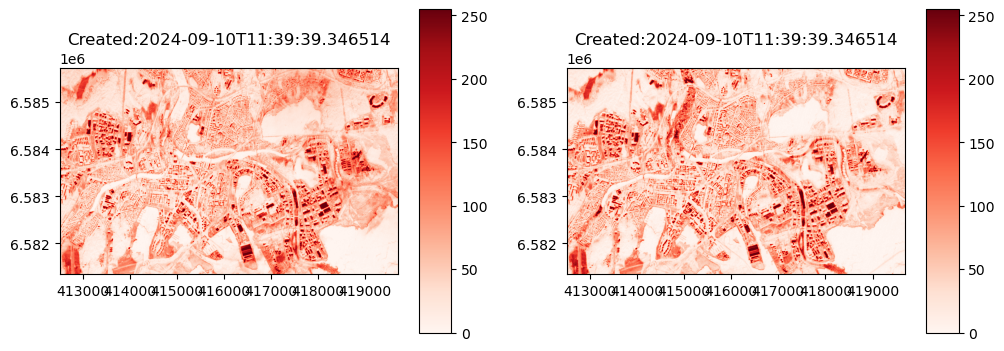

In [5]:
show_result(s2_image_data, 'Reds')

# Reduction

Reductions in OpenEO are operations that reduce the dimensionality of the data. The `reduce_dimension` process collapses a whole dimension of the datacube. It does so by using some sort of reducer, which is a function that calculates a single result from an amount of values, as e.g. mean(), min() and max() which is calculated over a specified dimension (e.g., time, bands).

![reduction](https://openeo.org/assets/img/dc_reduce.872f16c2.png)

Figure: Overview of reducing the sample datacube. Dimensions that are reduced are crossed out in the result images. Their information value has been compressed by a reducer function. We are going to have data from two dates:

In [6]:
s2.timespans.two_images

['2021-11-30T00:00:00Z', '2021-12-03T00:00:00Z']

### Time reduction
If we reduce the time and take the first we should only get the first image in the list.

{'loadcollection1': {'process_id': 'load_collection', 'arguments': {'bands': ['b04', 'b03', 'b02'], 'id': 's2_msi_l2a', 'spatial_extent': {'west': 13.460930954751282, 'east': 13.585449709728213, 'south': 59.36327761288911, 'north': 59.40107161575003}, 'temporal_extent': ['2021-11-30T00:00:00Z', '2021-12-03T00:00:00Z']}}, 'reducedimension1': {'process_id': 'reduce_dimension', 'arguments': {'data': {'from_node': 'loadcollection1'}, 'dimension': 't', 'reducer': {'process_graph': {'first1': {'process_id': 'first', 'arguments': {'data': {'from_parameter': 'data'}}, 'result': True}}}}, 'result': True}}


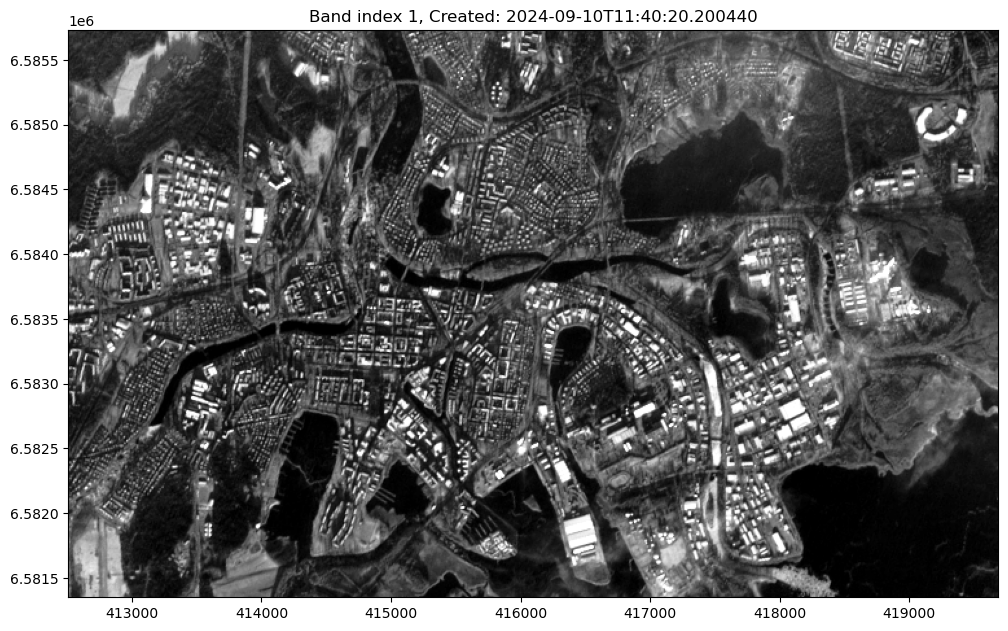

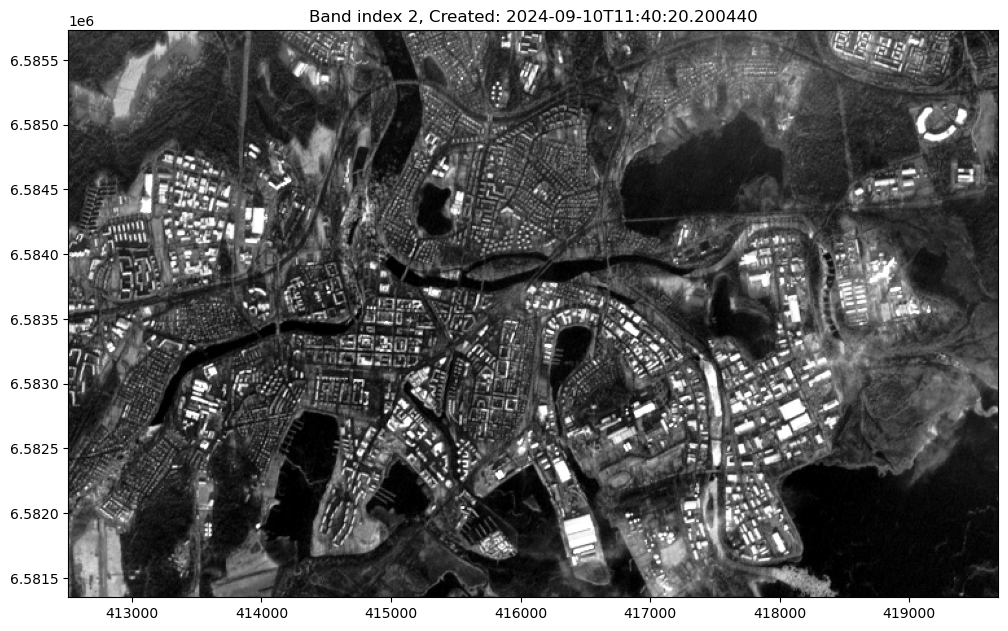

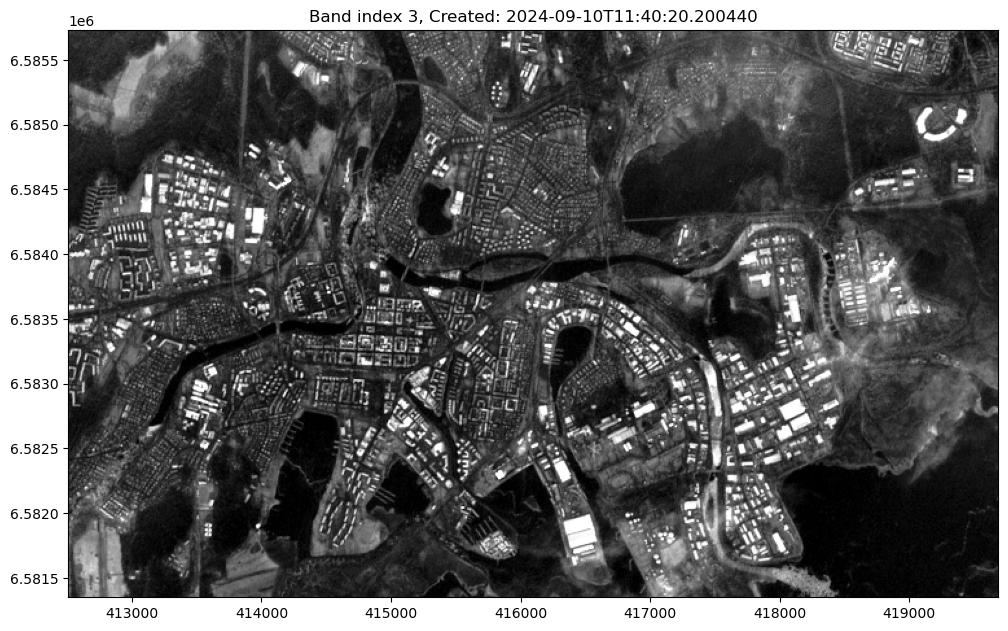

In [7]:
reduced_cube_over_time = s2_datacube.reduce_dimension(dimension="t", reducer="first")

# Show information
print(reduced_cube_over_time.flat_graph())
s2_image_data_reduced = reduced_cube_over_time.download(format="gtiff")
results_time_reduce=show_result(s2_image_data_reduced, colormap="Greys_r")

Let's check our results:

In [8]:
print("We expect a single raster to look at, number of rasters is:", len(results_time_reduce))
print("We should have multiple bands in the metadata, check the index:", results_time_reduce[0].indexes) 

We expect a single raster to look at, number of rasters is: 1
We should have multiple bands in the metadata, check the index: (1, 2, 3)


#### Note of caution

It's important to understand the operation that a reducer will apply. For example you can search for "first" in the openeo processes below:

In [ ]:
connection.list_processes()

And get an explanation along the lines of "Gives the first element of an array." along with examples. When we apply the "first" reduction together with the time dimension we take the **first** element in the list of images (it might not be the earliest image chronologically).

The min/max reducers combined with the time dimension will reduce take the min/max value **for each** pixel for each band. For example, in our case we have two images, the compution takes min/max value of each pixel in band 'b04' between the two. It proceeds with the rest of the bands and returns an array with the pixelwise results for each band. Hence the time dimension has indeed been removed (reduced), but we have also combined each of the bands and produced 3 new bands as a result. The calculation will **not** return the bands of the earliest/latest image. 

### Band reduction
Let's try to reduce the dimension over the bands instead. In this example we choose the mean. This means that we will take the mean of the two bands that we have available for each day.

{'loadcollection1': {'process_id': 'load_collection', 'arguments': {'bands': ['b04', 'b03', 'b02'], 'id': 's2_msi_l2a', 'spatial_extent': {'west': 13.460930954751282, 'east': 13.585449709728213, 'south': 59.36327761288911, 'north': 59.40107161575003}, 'temporal_extent': ['2021-11-30T00:00:00Z', '2021-12-03T00:00:00Z']}}, 'reducedimension1': {'process_id': 'reduce_dimension', 'arguments': {'data': {'from_node': 'loadcollection1'}, 'dimension': 'bands', 'reducer': {'process_graph': {'mean1': {'process_id': 'mean', 'arguments': {'data': {'from_parameter': 'data'}}, 'result': True}}}}, 'result': True}}


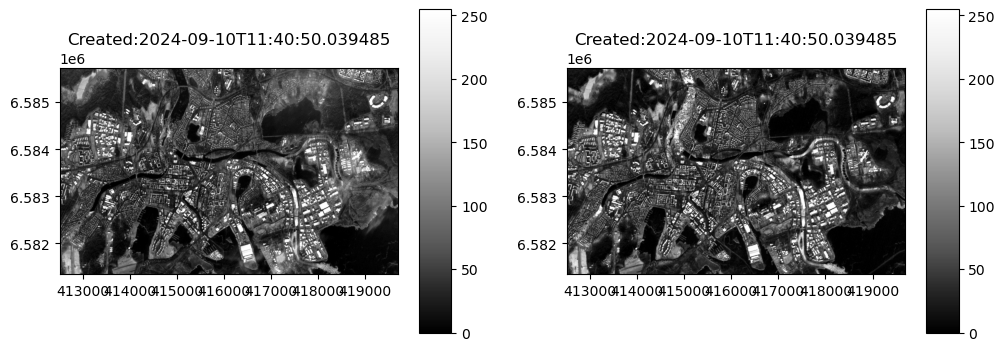

In [9]:
reduced_cube_over_bands = s2_datacube.reduce_dimension(dimension="bands", reducer="mean")

# Show information
print(reduced_cube_over_bands.flat_graph())
# reduced_cube_over_bands.metadata
s2_image_data_reduced = reduced_cube_over_bands.download(format="gtiff")
results_bands_reduce = show_result(s2_image_data_reduced, "Greys_r")

The figure show each image with the mean of Red, Blue, Green bands ('b04', 'b03', 'b02' respectively) in greyscale.

In [10]:
print("We expect multiple rasters to look at, number of rasters is:", 
      len(results_bands_reduce))
print("We should have multiple a single band in the metadata, check the index:", 
      results_bands_reduce[0].indexes) 

We expect multiple rasters to look at, number of rasters is: 2
We should have multiple a single band in the metadata, check the index: (1,)


We can also check if the calculation is correct. We first calculate the mean of the bands of the first pixel from the first image:

In [11]:
np.mean([results_time_reduce[0].read(1)[0,0], 
         results_time_reduce[0].read(2)[0,0], 
         results_time_reduce[0].read(3)[0,0]])

951.3333333333334

We compare it with the value of the single band in the first picture in the band reduce result:

In [12]:
results_bands_reduce[0].read(1)[0,0]

951.3333333333334

Calculation was successful!